In [8]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


'c:\program' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
# Data Overview
df = pd.read_excel(io="Online Retail.xlsx",sheet_name="Online Retail")
df.head()
df.info

(541909, 8)

In [15]:
df.describe()


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


The negative value of quantity represent for cancelled and refunded orders. In this analyse, we will focus on complete order only, the negative value of Quantity would be eleminated 

In [24]:
df = df.loc[df["Quantity"]> 0]

In [25]:
df.shape

(531285, 8)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531285 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      531285 non-null object
StockCode      531285 non-null object
Description    530693 non-null object
Quantity       531285 non-null int64
InvoiceDate    531285 non-null datetime64[ns]
UnitPrice      531285 non-null float64
CustomerID     397924 non-null float64
Country        531285 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.5+ MB


Explore about data


In [34]:
monthly_order_df = df.set_index("InvoiceDate")["InvoiceNo"].resample("M").nunique()

In [35]:
monthly_order_df

InvoiceDate
2010-12-31    1629
2011-01-31    1120
2011-02-28    1126
2011-03-31    1531
2011-04-30    1318
2011-05-31    1731
2011-06-30    1576
2011-07-31    1540
2011-08-31    1409
2011-09-30    1896
2011-10-31    2129
2011-11-30    2884
Freq: M, Name: InvoiceNo, dtype: int64

The number of invoice in 12-2011 is much smaller than other. That because it only contain data from 01-09 of December 2011. For easier analysis, I disregard data from 01-12-2011


In [33]:
 df = df[df["InvoiceDate"] < "2011-12-01"]

In [31]:
def plot_by_month_year(dataset,y_label):
    ax = pd.DataFrame(dataset.values).plot(grid=True, figsize=(10, 7), legend=False)
    ax.set_xlabel('date')
    ax.set_ylabel(y_label)
    ax.set_title('Total {} over time'.format(y_label))
    ax.set_ylim([0,max(dataset.values)])

    plt.xticks(range(len(dataset.index)),[x.strftime('%m.%Y') for x in dataset.index], rotation=45)
    plt.show()

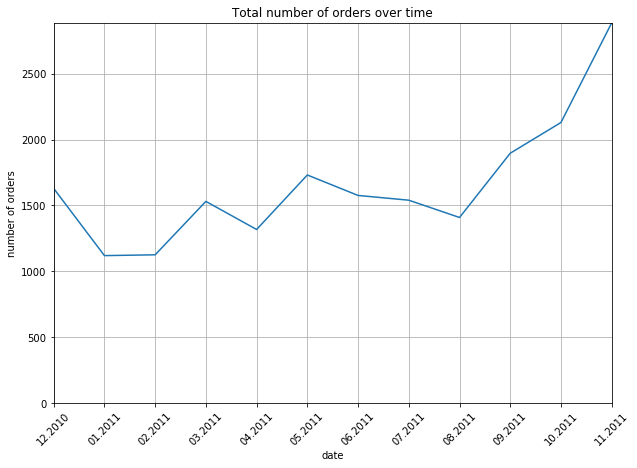

In [36]:
plot_by_month_year(monthly_order_df,"number of orders")

Next, analyse the repeat customer and the revenue over time

In [37]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [38]:
 #Create dataframe that has only one record for each purchase order/ sum up the sales of order with same invoiceNo at the same time
invoice_customer_df = df.groupby(["InvoiceNo","InvoiceDate"]).agg({"Sales": sum,"CustomerID":min,"Country": min}).reset_index()


Extract data to measure repeat customers

In [40]:
monthly_unique_customers_df = df.set_index("InvoiceDate")["CustomerID"].resample("M").nunique()

monthly_repeat_customers_df = invoice_customer_df.set_index("InvoiceDate").groupby([
        pd.Grouper(freq="M"), "CustomerID"
    ]).filter(lambda x: len(x) > 1).resample("M").nunique()["CustomerID"]

monthly_repeat_percentage = monthly_repeat_customers_df/monthly_unique_customers_df * 100.0

In [41]:
def comparision_chart(df1,df2,df3,y_label_left,y_label_right,title,lim):
    """
    :param df1: data from repeat customer
    :param df2: data from total unique customer
    :param df3: percentage values
    :param lim: set upper limit for y_axis of df1 and df2, lim must set based on higher total values
    :return:
    """
    ax1 = pd.DataFrame(df1.values).plot(grid= True, figsize=(10, 7))
    ax2_total = pd.DataFrame(df2.values).plot(grid= True,ax=ax1)
    ax3_percentage = pd.DataFrame(df3.values).plot(kind = "bar",ax=ax1,grid= True,secondary_y = True, color = "green",alpha=0.2)

    ax1.set_xlabel('date')
    ax1.set_ylabel(y_label_left)
    ax1.set_title(title)
    ax3_percentage.set_ylabel(y_label_right)
    ax1.set_ylim([0, df2.values.max() + lim])  # set range for y axis
    ax3_percentage.set_ylim([0, 100])

    ax1.legend(['From repeat customers', 'From all customers'])
    ax3_percentage.legend(['Percentage of Repeat'], loc='upper right')
    plt.xticks(
        range(len(df1.index)),[x.strftime('%m.%Y') for x in df1.index], rotation=45)
    plt.show()


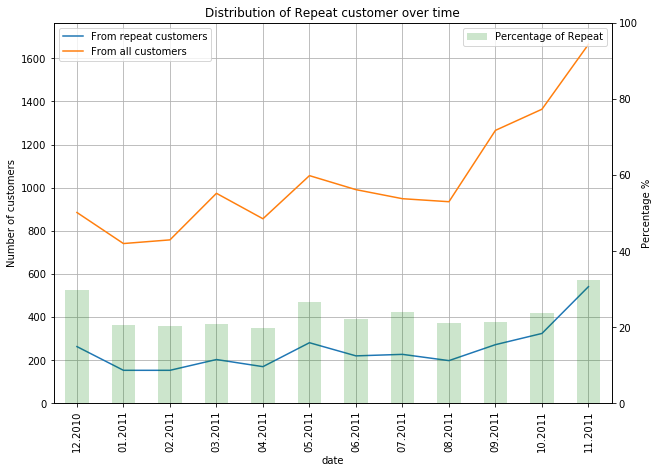

In [42]:
comparision_chart(monthly_repeat_customers_df,monthly_unique_customers_df,monthly_repeat_percentage,"Number of customers","Percentage %","Distribution of Repeat customer over time",100)

Analyse revenue from repeat customers

In [43]:
monthly_revenue_df = df.set_index("InvoiceDate")["Sales"].resample("M").sum()

monthly_revenue_repeat_customer_df = invoice_customer_df.set_index("InvoiceDate").groupby([
        pd.Grouper(freq="M"),"CustomerID"]).filter(lambda x: len(x) >1).resample("M").sum()["Sales"]
monthly_revenue_percentage = monthly_revenue_repeat_customer_df/monthly_revenue_df * 100


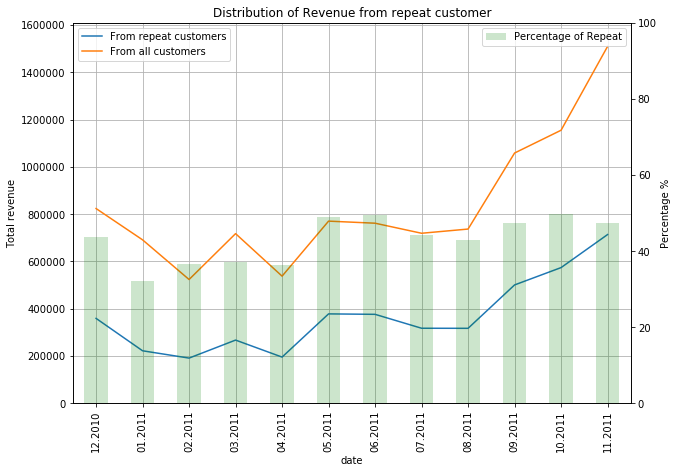

In [44]:
comparision_chart(monthly_revenue_repeat_customer_df,monthly_revenue_df,monthly_revenue_percentage,"Total revenue","Percentage %","Distribution of Revenue from repeat customer",100000)

Find our trend item over time

In [45]:
items_df = df.set_index("InvoiceDate").groupby([pd.Grouper(freq="M"), "StockCode"])["Quantity"].sum()

In [59]:
# Rank items 
sorted_items = items_df.sort_values(ascending=False).reset_index()
last_month_sorted_items = items_df.loc["2011-11-30"].sort_values(ascending=False).reset_index()

Top 5 product codes of last month is 23084, 84826, 22197, 22086, 85099B

Top 5 product codes of the whole year is 23166, 23084, 84826, 22197, 84077

Now extract the data of these product code

In [62]:
best_items = df.loc[df["StockCode"].isin([23084, 84826, 22197, 22086, "85099B",23116,22197,84077])
                    ].set_index("InvoiceDate").groupby([pd.Grouper(freq="M"), "StockCode"
                                                       ])["Quantity"].sum()

In [64]:
best_itmes_df = best_items.reset_index().pivot("InvoiceDate","StockCode").fillna(0)

best_itmes_df = best_itmes_df.reset_index()
best_itmes_df = best_itmes_df.set_index("InvoiceDate")
best_itmes_df.columns = best_itmes_df.columns.droplevel(0)

In [65]:
best_itmes_df

StockCode,22086,22197,23084,23116,84077,84826,85099B
InvoiceDate,,,,,,,
2010-12-31,2460.0,2738.0,0.0,0.0,5195.0,366.0,2152.0
2011-01-31,24.0,1824.0,0.0,0.0,1492.0,480.0,2747.0
2011-02-28,5.0,2666.0,0.0,0.0,3518.0,66.0,3080.0
2011-03-31,87.0,2803.0,0.0,0.0,3888.0,60.0,5282.0
2011-04-30,13.0,1869.0,0.0,0.0,10239.0,1.0,2456.0
2011-05-31,17.0,6849.0,1131.0,0.0,4949.0,0.0,3621.0
2011-06-30,344.0,2095.0,1713.0,0.0,2122.0,4.0,3682.0
2011-07-31,383.0,1876.0,318.0,0.0,3762.0,2.0,3129.0
2011-08-31,490.0,5421.0,2267.0,0.0,2261.0,72.0,5502.0


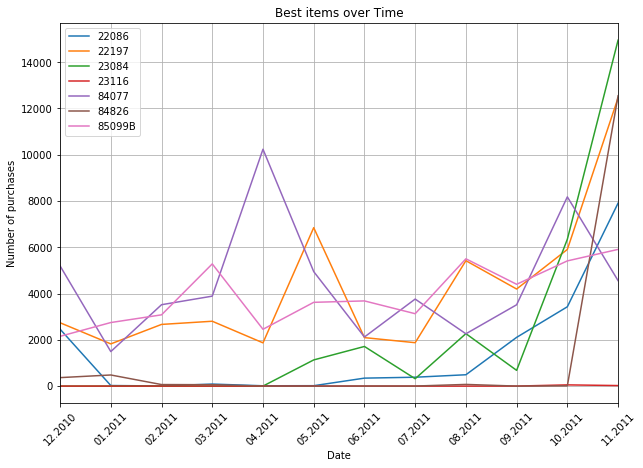

In [69]:
# Plot the best items

ax = pd.DataFrame(best_itmes_df.values).plot(grid=True, figsize=(10,7))

ax.set_ylabel("Number of purchases")
ax.set_xlabel("Date")
ax.set_title("Best items over Time")

ax.legend(best_itmes_df.columns, loc='upper left')

plt.xticks(range(len(best_itmes_df.index)), [x.strftime('%m.%Y') for x in best_itmes_df.index], 
    rotation=45)

plt.show()